In [1]:
#! Simulator
from casadi import *
from numpy import *
import matplotlib.pyplot as plt

In [80]:
N = 200 # number of control intervals

M = 5.0
m = 0.5
L = 1.0
g = 9.8

# Damping factor
D = 0.02


opti = Opti() # Optimization problem

# ---- decision variables ---------
X = opti.variable(4,N+1) # state trajectory x, xD, theta, thetaD
x = X[0,:]
xD = X[1,:]
theta = X[2,:]
thetaD = X[3,:]

U = opti.variable(1,N)   # control trajectory (accleration, phi_dot)
force = U[0,:]

T = 20      # Total time

# ---- dynamic constraints --------

def f(x, u):
    # x = [x, xD, theta, thetaD]
    xDD = ( 1 / (M+m*np.sin(x[2])**2) ) * ( u + m*np.sin(x[2]) * (L*x[3]**2 + g*np.cos(x[2])) )
    tDD = ( 1 / (L * (M+m*np.sin(x[2])**2)) ) * ( -u*np.cos(x[2]) - m*L*(x[3]**2)*np.cos(x[2])*np.sin(x[2]) - (M+m)*g*np.sin(x[2]) )
    return vertcat(x[1]+xDD*(dt+D),xDD, x[3]+tDD*(dt+D), tDD)

dt = T/N # length of a control interval
for k in range(N): # loop over control intervals
    # Runge-Kutta 4 integration
    k1 = f(X[:,k],         U[:,k])
    k2 = f(X[:,k]+dt/2*k1, U[:,k])
    k3 = f(X[:,k]+dt/2*k2, U[:,k])
    k4 = f(X[:,k]+dt*k3,   U[:,k])
    x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 
    opti.subject_to(X[:,k+1]==x_next) # close the gaps

# ---- constraints -----------
# # State limits
# opti.subject_to(opti.bounded(-7.75, v, 77.75))   # track speed limit
# opti.subject_to(opti.bounded(-0.58206731, phi, 0.58206731))   # steering angle limit
# Control limits
opti.subject_to(opti.bounded(-50.0, force, 50.0))   # steering angle limit
opti.subject_to(opti.bounded(-2.5, x, 2.5))

# ---- Initial conditions --------
opti.subject_to(x[0]==0)   # start at position 0 ...
opti.subject_to(theta[0]==0)   # start at position 0 ...
opti.subject_to(xD[0]==0) # ... from stand-still 
opti.subject_to(thetaD[0]==0)

# Final Conditions
opti.subject_to((theta[50:]-np.pi)**2 <= 0.08)
# opti.subject_to(thetaD[-1]==0)

# ---- initial values for solver ---
opti.set_initial(force, 50.0)
# opti.set_initial(phi, 0.0)
# opti.set_initial(T, 1)

# ---- objective          ---------
opti.minimize( sum([cos(theta[k]) for k in range(N)]) + 1.2 * sum([(force[k]/50)**2 for k in range(N)]) ) # race in minimal time

# ---- solve NLP              ------
opti.solver("ipopt") # set numerical backend
sol = opti.solve()   # actual solve

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3804
Number of nonzeros in inequality constraint Jacobian.:      552
Number of nonzeros in Lagrangian Hessian.............:     1201

Total number of variables............................:     1004
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      804
Total number of inequality constraints...............:      552
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      401
        inequality constraints with only upper bounds:      151

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

  81 -1.1948993e+002 6.13e-002 4.36e-001  -2.5 2.48e+001  -3.5 2.54e-001 3.42e-001f  1
  82 -1.1974810e+002 5.56e-002 3.97e-001  -2.5 4.71e+001  -4.0 2.69e-001 1.09e-001f  1
  83 -1.2011217e+002 6.40e-002 4.85e-001  -2.5 5.42e+002    -  1.22e-002 1.78e-002f  1
  84 -1.2037850e+002 6.89e-002 5.06e-001  -2.5 6.62e+002  -4.5 2.27e-002 1.27e-002f  1
  85 -1.2085818e+002 1.09e-001 9.38e-001  -2.5 4.03e+001  -4.0 9.11e-002 6.10e-001f  1
  86 -1.2098346e+002 9.95e-002 8.56e-001  -2.5 2.97e+001    -  2.40e-002 8.61e-002h  1
  87 -1.2109557e+002 9.27e-002 7.97e-001  -2.5 2.17e+001    -  6.88e-002 7.22e-002f  1
  88 -1.2119301e+002 9.05e-002 7.78e-001  -2.5 7.65e+001    -  4.13e-002 2.34e-002f  1
  89 -1.2135011e+002 8.76e-002 7.50e-001  -2.5 8.33e+001    -  2.97e-001 3.57e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -1.2158893e+002 8.34e-002 7.03e-001  -2.5 8.74e+001    -  1.01e-001 6.30e-002f  1
  91 -1.2189208e+002 8.42e-002 6.46e-001  -2.5 6.

 179 -1.3669021e+002 2.43e-009 1.52e-004  -8.6 7.09e-003    -  4.94e-001 6.07e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 -1.3669021e+002 5.77e-011 2.27e-004  -8.6 5.44e-003    -  7.37e-001 1.00e+000f  1
 181 -1.3669021e+002 6.09e-013 1.88e-011  -8.6 1.60e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 181

                                   (scaled)                 (unscaled)
Objective...............: -1.3669021280292350e+002  -1.3669021280292350e+002
Dual infeasibility......:  1.8787527089614287e-011   1.8787527089614287e-011
Constraint violation....:  6.0929039591428591e-013   6.0929039591428591e-013
Complementarity.........:  3.8050511864259552e-009   3.8050511864259552e-009
Overall NLP error.......:  3.8050511864259552e-009   3.8050511864259552e-009


Number of objective function evaluations             = 204
Number of objective gradient evaluations             = 181
Number of equality constraint evaluations         

<IPython.core.display.Javascript object>


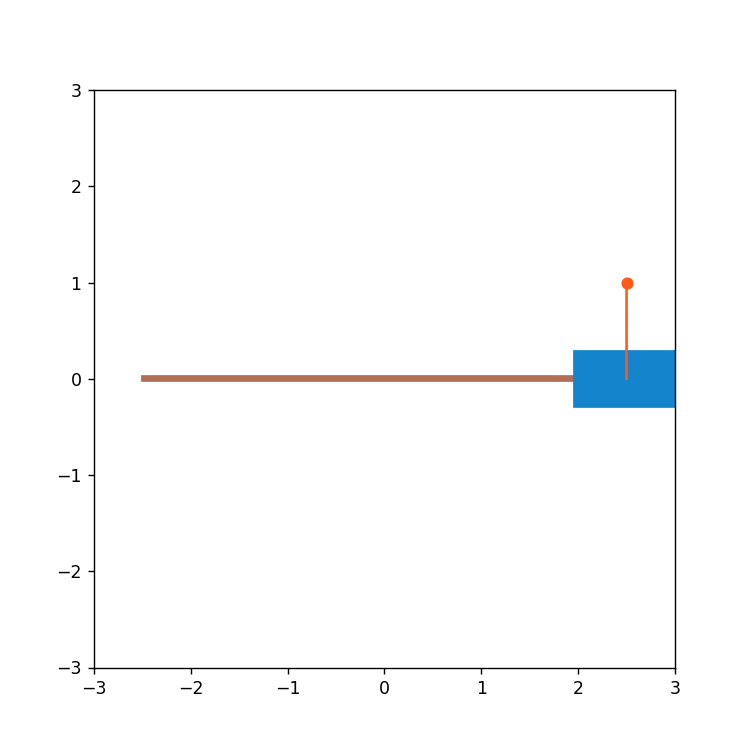

In [85]:
# Plotting Live
%matplotlib notebook
import matplotlib.patches as patches

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

# Origin
orig_y = 0.0
bsizex = (M/3)*0.65
bsizey = (M/3)*0.35

x = sol.value(x)
theta = sol.value(theta)

for i in range(0, x.shape[0]):
    
    ax.clear()
    ax.set_xlim(-3,3)
    ax.set_ylim(-3,3)
    
    # Getting new positions
    cx = x[i]
    cy = orig_y
    
    rect = patches.Rectangle((cx-bsizex/2,cy-bsizey/2),bsizex,bsizey,linewidth=1,color='#1485CC',fill=True)
    line = patches.Rectangle((-2.5,-0.025),5,0.05,linewidth=1,color='#B26E54',fill=True)
    
    px = cx + L*np.sin(theta[i])
    py = cy - L*np.cos(theta[i])
    
    # Plotting the latest position
    ax.add_patch(line)
    ax.plot([cx, px], [cy, py], color='#FF5919')
    ax.add_patch(rect)
    ax.scatter(px, py, color='#FF5919')
    fig.canvas.draw()
    
    plt.pause(dt/2)
    
plt.show()